**Статистический анализ данных по аренде самокатов в сервисе GoFast**

**Постановка задачи**

Заказчиком данного исследования является сервис аренды самокатов GoFast. Цель исследования — анализ данных пользователей из нескольких городов, которые используют сервис GoFast для поездок. На основе этих данных предстоит проверить ряд гипотез о длительности поездок, пройденном расстоянии, помесячной выручке и влиянии технических обновлений. Кроме того, необходимо определить минимальное количество промокодов для достижения плана и построить график распределения, чтобы оценить открываемость push-уведомлений.

**О сервисе GoFast**

Пользователи могут пользоваться сервисом двумя способами:

**1.Без подписки:**

- Абонентская плата отсутствует
- Стоимость одной минуты поездки — 8 рублей
- Стоимость начала поездки — 50 рублей

**2.С подпиской Ultra:**

- Абонентская плата — 199 рублей в месяц
- Стоимость одной минуты поездки — 6 рублей
- Стоимость начала поездки — бесплатно


**Цель исследования**

Проверить следующие гипотезы:

- Пользователи с подпиской проводят в поездках в среднем больше времени, чем пользователи без подписки.
- Пользователи в среднем проезжают расстояние менее 3130 метров.
- Помесячная выручка от пользователей с подпиской выше, чем от пользователей без подписки.
- Количество обращений в техподдержку значительно снизилось после технического обновления сервера приложения.

Дополнительно необходимо построить два распределения для маркетингового отдела:

- Стратегия распространения промокодов для продления подписок.
- Оценка вероятности открытия push-уведомлений в мобильном приложении.


**Ход исследования**

Данные будут получены из файлов:

- /datasets/users_go.csv (данные о пользователях),

- /datasets/rides_go.csv (данные о поездках),

- /datasets/subscriptions_go.csv (данные о подписках).


Качество данных неизвестно, поэтому первым шагом будет их обзор. После этого планируется проверка данных на наличие ошибок и оценка их влияния на исследование. На этапе предобработки будут исправлены наиболее критичные ошибки. Затем проводится исследовательский анализ для выявления основных закономерностей. Данные будут объединены и структурированы в различные датафреймы, после чего будет произведен расчет выручки. Заключительным этапом станет проверка гипотез и построение распределений для маркетингового отдела.

**Этапы исследования**

- Обзор данных.
- Предобработка данных.
- Исследовательский анализ данных.
- Объединение и структурирование данных.
- Подсчет выручки.
- Проверка гипотез.

<style>
    Статистический анализ данных по аренде самокатов в сервисе GoFast
  table {
    font-size: 20px;
  }
</style>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from scipy.stats import binom
from IPython.display import display


#### Шаг 1. Загрузка данных

In [2]:
users_go = pd.read_csv('/datasets/users_go.csv')
rides_go = pd.read_csv('/datasets/rides_go.csv')
subscriptions_go = pd.read_csv('/datasets/subscriptions_go.csv')

#### Шаг 1. 2 Выведем первые строки каждого набора данных. Изучим общую информацию о каждом датафрейме.

In [3]:
#Вывод первых строк
display(users_go.head())
display(rides_go.head())
display(subscriptions_go.head())

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


**Изучение инфо о датафреймах**

In [4]:
# Инфо по данным пользователей
print(users_go.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB
None


Вывод: Данные о пользователях полные, без пропущенных значений. Информация включает основные атрибуты, такие как идентификатор, имя, возраст, город и тип подписки.


In [5]:
# Инфо по данным по поездкам
print(rides_go.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB
None


Вывод: Данные о поездках содержат информацию о расстоянии, продолжительности, дате и месяце каждой поездки. Здесь также нет пропущенных значений, что позволяет сразу переходить к анализу данных.

In [6]:
# Инфо по данным о подписках
print(subscriptions_go.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes
None


Вывод:
Этот датафрейм содержит настройки стоимости поездок для двух типов подписок. Данные полные, что позволяет использовать их для расчёта выручки и сравнения типов подписок.

#### Шаг 2. Предобработка данных

**2.1 Приведение столбца date к типу даты pandas**

In [7]:
rides_go['date'] = pd.to_datetime(rides_go['date'])

min_date = rides_go['date'].min()
max_date = rides_go['date'].max()

print(f"Диапазон дат: с {min_date} по {max_date}")

Диапазон дат: с 2021-01-01 00:00:00 по 2021-12-30 00:00:00


**2.2 Создание нового столбца с номером месяца на основе столбца date**

In [8]:
rides_go['month'] = rides_go['date'].dt.month

In [9]:
#Проверка минимальной и максимальной продолжительности поездок
min_duration = rides_go['duration'].min()
max_duration = rides_go['duration'].max()

print(f"Минимальная продолжительность поездки: {min_duration} минут")
print(f"Максимальная продолжительность поездки: {max_duration} минут")

Минимальная продолжительность поездки: 0.5 минут
Максимальная продолжительность поездки: 40.82396261922424 минут


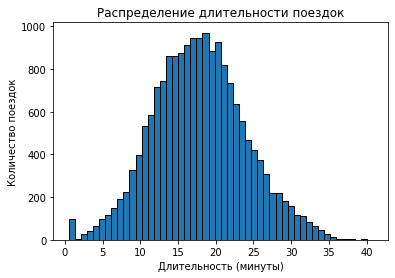

In [10]:
#Гистограмма распределения длительности поездок
plt.hist(rides_go['duration'], bins=50, edgecolor='black')
plt.title('Распределение длительности поездок')
plt.xlabel('Длительность (минуты)')
plt.ylabel('Количество поездок')
plt.show()

**2.3 Проверка наличия пропущенных значений и дубликатов**

In [11]:
# Проверяем пропущенные значения
print(users_go.isnull().sum())
print(rides_go.isnull().sum())
print(subscriptions_go.isnull().sum())

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64
user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64
subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64


In [12]:
# Проверяем дубликаты
print(users_go.duplicated().sum())
print(rides_go.duplicated().sum())
print(subscriptions_go.duplicated().sum())

31
0
0


**Обработка пропусков и дубликатов**

In [13]:
# Удаление дубликатов
users_go = users_go.drop_duplicates()
rides_go = rides_go.drop_duplicates()
subscriptions_go = subscriptions_go.drop_duplicates()


In [14]:
# Заполнение пропусков средним значением для числовых столбцов
rides_go.fillna(rides_go.mean(numeric_only=True), inplace=True)

Вывод: 

В ходе предобработки данных были проведены следующие шаги:

1. Приведение столбца date к типу даты:

- Данные о поездках (rides_go) содержат даты в диапазоне с 1 января 2021 года по 30 декабря 2021 года. Диапазон указывает, что данные охватывают почти полный год 2021.
- В данном случае все данные относятся к одному году, поэтому создание отдельного столбца с годом не понадобилось.

2. Создание нового столбца с номером месяца:

- Был добавлен столбец month, содержащий номер месяца, извлеченный из столбца date. Это позволяет использовать данные для помесячного анализа.

3. Анализ длительности поездок:

- Минимальная продолжительность поездки составила 0.5 минут, что указывает на то, что в данных отсутствуют нулевые или отрицательные значения длительности, что могло бы указывать на ошибки.
- Максимальная продолжительность поездки — около 40.8 минут. Гистограмма распределения длительности показала, что длительность поездок находится в адекватном диапазоне и не содержит явных аномалий.

4. Проверка наличия пропущенных значений:

- Пропущенные значения отсутствуют во всех трех наборах данных: users_go, rides_go и subscriptions_go. Это говорит о высоком качестве данных и об отсутствии необходимости в дальнейшей обработке пропусков.

5. Проверка наличия дубликатов:

- В данных о пользователях (users_go) был обнаружен 31 дубликат. Они были удалены, чтобы избежать возможного искажения результатов анализа.
- В данных о поездках (rides_go) и подписках (subscriptions_go) дубликаты отсутствуют.

6. Обработка пропусков и дубликатов:

- Дубликаты в данных о пользователях успешно удалены.

#### Шаг 3. Исследовательский анализ данных

**3.1 Частота встречаемости городов**




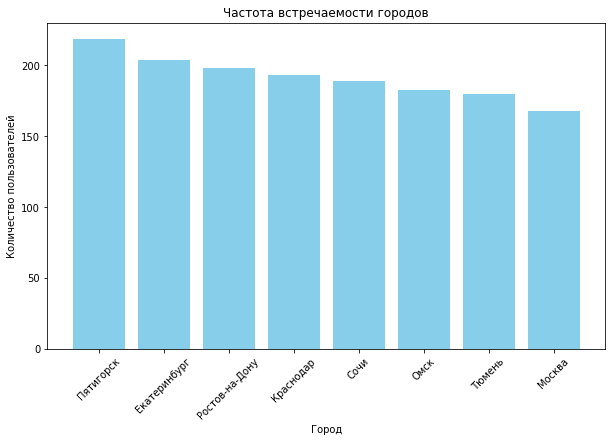

In [15]:
# Построим гистограмму, показывающую количество пользователей в каждом городе
# Частота встречаемости городов
city_count = users_go['city'].value_counts()

plt.figure(figsize=(10,6))
plt.bar(city_count.index, city_count.values, color='skyblue')
plt.title('Частота встречаемости городов')
plt.xticks(rotation=45)
plt.xlabel('Город')
plt.ylabel('Количество пользователей')
plt.show()

Вывод: Основная часть пользователей сосредоточена в нескольких городах, возможно, крупных мегаполисах, что указывает на приоритетные регионы для компании.

**3.2 Cоотношение пользователей с подпиской и без подписки**

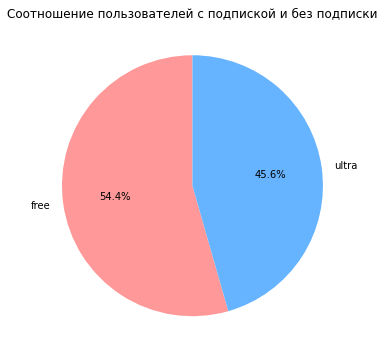

In [16]:
# Соотношение пользователей с подпиской и без подписки
subscription_count = users_go['subscription_type'].value_counts()

plt.figure(figsize=(6,6))
plt.pie(subscription_count, labels=subscription_count.index, autopct='%1.1f%%', startangle=90, colors=['#ff9999', '#66b3ff'])
plt.title('Соотношение пользователей с подпиской и без подписки')
plt.show()

Вывод: Большая часть пользователей не имеет подписку, но при этом 45.6% ее имеет, что свидетельствует о высокой популярности платных тарифов и их выгоде для пользователей.


**3.3 Возраст пользователей**


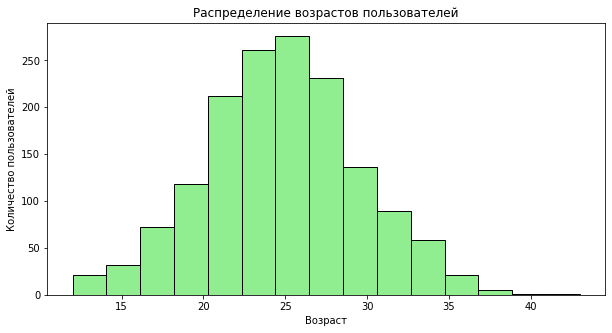

In [17]:
plt.figure(figsize=(10,5))
plt.hist(users_go['age'], bins=15, color='lightgreen', edgecolor='black')
plt.title('Распределение возрастов пользователей')
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.show()

Вывод: Основная часть пользователей находится в возрастных диапазонах 20-30 лет, что указывает на популярность сервиса среди молодых людей.

**3.4 Расстояние, которое пользователь преодолел за одну поездку**

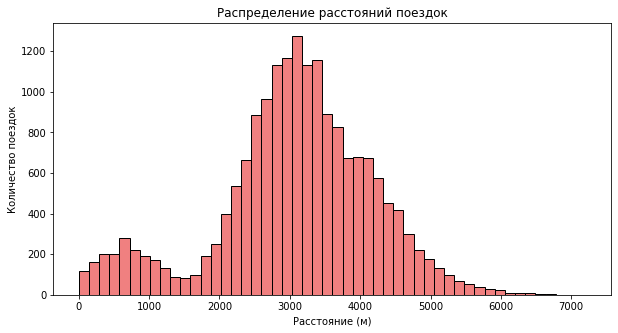

In [18]:
plt.figure(figsize=(10,5))
plt.hist(rides_go['distance'], bins=50, color='lightcoral', edgecolor='black')
plt.title('Распределение расстояний поездок')
plt.xlabel('Расстояние (м)')
plt.ylabel('Количество поездок')
plt.show()

Вывод: Большая часть поездок составляет средние расстояния в 3100 м, что может указывать на частое использование сервиса для средних поездок.

**3.5 Продолжительность поездок**

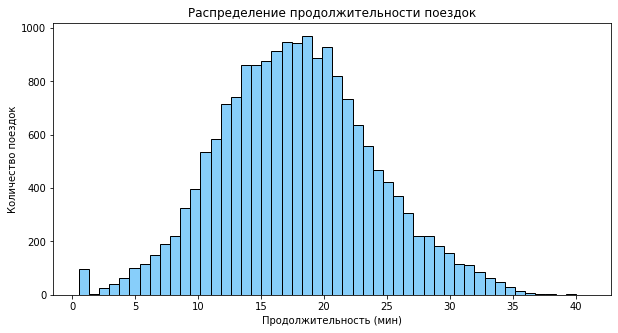

In [19]:
plt.figure(figsize=(10,5))
plt.hist(rides_go['duration'], bins=50, color='lightskyblue', edgecolor='black')
plt.title('Распределение продолжительности поездок')
plt.xlabel('Продолжительность (мин)')
plt.ylabel('Количество поездок')
plt.show()

Вывод: Большинство поездок имеют среднюю продолжительность 15-22 минуты, что указывает на популярность краткосрочного использования сервиса для повседневных нужд.

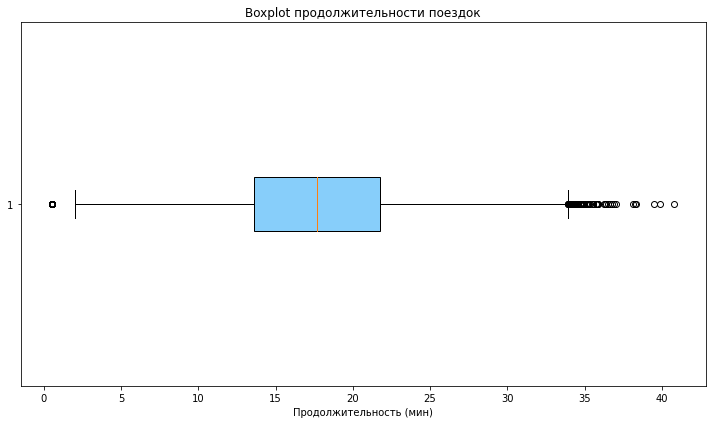

In [20]:
# Боксплот продолжительности поездок
plt.figure(figsize=(10, 6))
plt.boxplot(rides_go['duration'], vert=False, patch_artist=True, boxprops=dict(facecolor='lightskyblue'))
plt.title('Boxplot продолжительности поездок')
plt.xlabel('Продолжительность (мин)')
plt.tight_layout()
plt.show()

Вывод: Большинство пользователей предпочитают использовать сервис GoFast для коротких поездок, что согласуется с предполагаемой целью использования самокатов — быстрое перемещение на небольшие расстояния. Боксплот показывает некоторую вариативность в продолжительности поездок и наличие выбросов, указывая на то, что в данных есть как очень короткие, так и несколько длительных поездок. Однако эти выбросы не сильно влияют на общее распределение, так как основная масса данных сосредоточена вокруг среднего значения.

#### Шаг 4. Объединение данных

4.1 Объединение данных о пользователях и поездках

In [21]:
#Размеры датасетов до объединения
print(f"Размер датафрейма users_go: {users_go.shape}")
print(f"Размер датафрейма rides_go: {rides_go.shape}")
print(f"Размер датафрейма subscriptions_go: {subscriptions_go.shape}")

Размер датафрейма users_go: (1534, 5)
Размер датафрейма rides_go: (18068, 5)
Размер датафрейма subscriptions_go: (2, 4)


In [22]:
merged_df = pd.merge(users_go, rides_go, on='user_id', how='left')
merged_df.head(5)

,user_id,name,age,city,subscription_type,distance,duration,date,month
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8


Объединим полученный датафрейм с данными о подписках

In [23]:
final_df = pd.merge(merged_df, subscriptions_go, on='subscription_type', how='left')
final_df.head(5)
print(f"Размер датафрейма final_df (после объединения с subscriptions_go): {final_df.shape}")

Размер датафрейма final_df (после объединения с subscriptions_go): (18068, 12)


4.2 Создадим ещё два датафрейма из датафрейма, созданного на этапе 4.1

In [24]:
#Датафрейм с пользователями без подписки (free)
no_subscription_df = final_df[final_df['subscription_type'] == 'free']
display(no_subscription_df.head(5))

#Датафрейм с пользователями с подпиской (ultra)
with_subscription_df = final_df[final_df['subscription_type'] == 'ultra']
with_subscription_df.head(5)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0


,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


4.3 Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий.


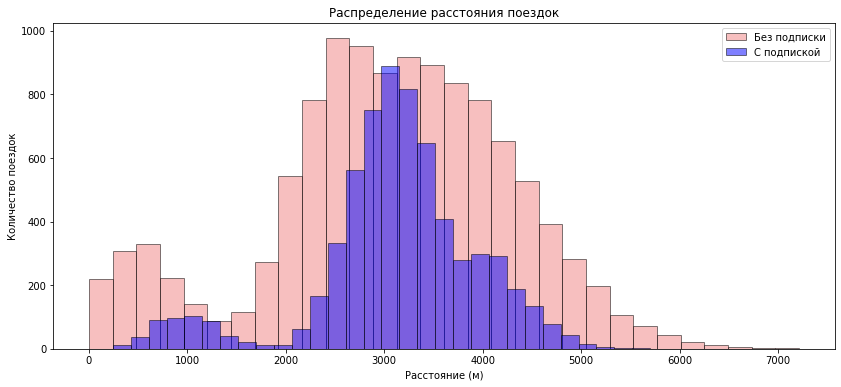

In [25]:
#Визуализация данных о расстоянии поездок
plt.figure(figsize=(14, 6))
plt.hist(no_subscription_df['distance'], bins=30, color='lightcoral', alpha=0.5, label='Без подписки', edgecolor='black')
plt.hist(with_subscription_df['distance'], bins=30, color='blue', alpha=0.5, label='С подпиской', edgecolor='black')
plt.title('Распределение расстояния поездок')
plt.xlabel('Расстояние (м)')
plt.ylabel('Количество поездок')
plt.legend()
plt.show()


In [26]:
#Описание расстояния без подписки
no_subscription_df['distance'].describe().round(2)

count    11568.00
mean      3045.50
std       1246.17
min          0.86
25%       2366.56
50%       3114.65
75%       3905.70
max       7211.01
Name: distance, dtype: float64

In [27]:
#Описание расстояния с подпиской
with_subscription_df['distance'].describe().round(2)

count    6500.00
mean     3115.45
std       836.90
min       244.21
25%      2785.44
50%      3148.64
75%      3560.57
max      5699.77
Name: distance, dtype: float64

Вывод:
Средняя продолжительность расстояний поездок пользователей с подпиской немного выше (3115.45 м) по сравнению с пользователями без подписки (3045.50 м), но разница незначительна.
Распределение расстояний у пользователей без подписки имеет большую дисперсию, так как стандартное отклонение (1246.17 м) больше, чем у пользователей с подпиской (836.90 м). Это указывает на более разнообразные по длине поездки у пользователей без подписки.
Максимальное расстояние для пользователей без подписки (7211.01 м) заметно выше, чем у пользователей с подпиской (5699.77 м).

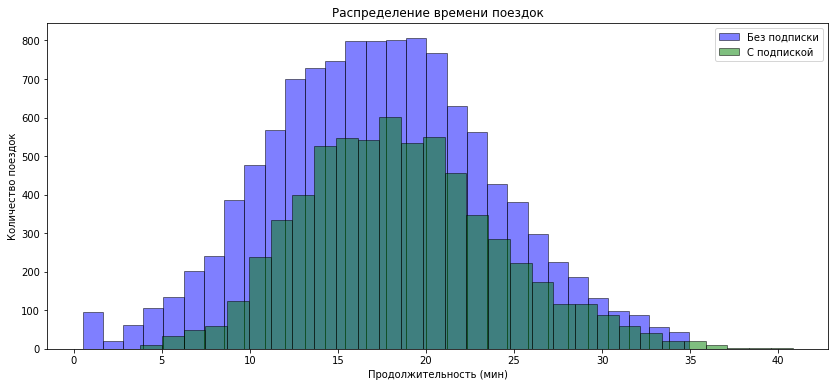

In [28]:
# Визуализация данных о времени поездок
plt.figure(figsize=(14, 6))
plt.hist(no_subscription_df['duration'], bins=30, color='blue', alpha=0.5, label='Без подписки', edgecolor='black')
plt.hist(with_subscription_df['duration'], bins=30, color='green', alpha=0.5, label='С подпиской', edgecolor='black')
plt.title('Распределение времени поездок')
plt.xlabel('Продолжительность (мин)')
plt.ylabel('Количество поездок')
plt.legend()
plt.show()

In [29]:
#Описание данных о продолжнительности поездок без подписки
no_subscription_df['distance'].round(2).describe()

count    11568.000000
mean      3045.495284
std       1246.173810
min          0.860000
25%       2366.560000
50%       3114.650000
75%       3905.695000
max       7211.010000
Name: distance, dtype: float64

In [30]:
#Описание данных о продолжнительности поездок с подпиской
with_subscription_df['distance'].round(2).describe()

count    6500.000000
mean     3115.445431
std       836.895369
min       244.210000
25%      2785.447500
50%      3148.640000
75%      3560.577500
max      5699.770000
Name: distance, dtype: float64

Вывод:
Средняя продолжительность поездок для пользователей с подпиской несколько выше (3115,44), чем у пользователей без подписки(3045,49). Это говорит о том, что пользователи с подпиской не только проезжают большие расстояния, но и тратят больше времени на поездки.
Более детальное сравнение статистики времени позволит уточнить, насколько значимы эти различия, однако, визуализация уже показывает тенденцию к более длительным поездкам среди подписчиков.

Общий вывод:
Визуализация и описательная статистика свидетельствуют о том, что пользователи с подпиской склонны к более длительным и протяжённым поездкам по сравнению с пользователями без подписки.
Несмотря на то, что распределения расстояний и времени поездок для обеих групп перекрываются, пользователи с подпиской имеют тенденцию к более высокому среднему расстоянию и времени.
Чтобы подтвердить эти наблюдения статистически, стоит дополнительно провести тесты значимости.

#### Шаг 5. Подсчёт выручки

In [31]:
# Проверка на пропуски в final_df
print(final_df.isnull().sum())

#Обработка пропусков, при наличии
final_df.fillna({
    'distance': 0,
    'duration': 0,
    'subscription_type': 'free',
    'minute_price': 0,
    'start_ride_price': 0,
    'subscription_fee': 0
}, inplace=True)


user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month                0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64


5.1 Агрегируем данные о поездках

In [32]:
#Округлим продолжительность поездок до целого числа
final_df['duration'] = np.ceil(final_df['duration']).astype(int)
final_df.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,26,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,16,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,7,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,19,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,27,2021-08-28,8,6,0,199


In [33]:
monthly_data = final_df.groupby(['user_id', 'month']).agg(
    total_distance=('distance', 'sum'),
    trip_count=('distance', 'size'),
    total_duration=('duration', 'sum')
).reset_index()

5.2 Рассчитем ежемесячный доход

In [34]:
#Объединим агрегированные данные с данными о подписках
monthly_data = final_df.groupby(['user_id', 'month']).agg(
    total_distance=('distance', 'sum'),
    trip_count=('distance', 'size'),
    total_duration=('duration', 'sum')
).reset_index()

In [35]:
# Объединим subscription_type с monthly_data
user_subscriptions = final_df[['user_id', 'subscription_type']].drop_duplicates()
monthly_data = pd.merge(monthly_data, user_subscriptions, on='user_id', how='left')
monthly_data = pd.merge(monthly_data, subscriptions_go, on='subscription_type', how='left')

In [36]:
#Определим функцию для подсчета ежемесячной выручки (с подпиской и без)
def calculate_revenue(row):
    if row['subscription_type'] == 'free':
        return (row['trip_count'] * row['start_ride_price']) + (row['total_duration'] * row['minute_price'])
    else:
        return (row['trip_count'] * row['start_ride_price']) + (row['total_duration'] * row['minute_price']) + row['subscription_fee']

In [37]:
#Расчитаем ежемесячную выручку для каждого пользователя
monthly_data['monthly_revenue'] = monthly_data.apply(calculate_revenue, axis=1)
print(monthly_data.head())
print ('Выручка за год:',monthly_data['monthly_revenue'].sum(), 'руб.')

   user_id  month  total_distance  trip_count  total_duration  \
0        1      1     7027.511294           2              42   
1        1      4      754.159807           1               7   
2        1      8     6723.470560           2              46   
3        1     10     5809.911100           2              32   
4        1     11     7003.499363           3              56   

  subscription_type  minute_price  start_ride_price  subscription_fee  \
0             ultra             6                 0               199   
1             ultra             6                 0               199   
2             ultra             6                 0               199   
3             ultra             6                 0               199   
4             ultra             6                 0               199   

   monthly_revenue  
0              451  
1              241  
2              475  
3              391  
4              535  
Выручка за год: 3878641 руб.


Вывод:
Выручка от аренды самокатов за год составила 3 878 641.0 руб.

#### Шаг 6. Проверка гипотез

**Тратят ли подписчики больше времени на поездки?**

Необходимо проверить, тратят ли пользователи с подпиской (ultra) больше времени на поездки по сравнению с пользователями без подписки (free). Это сравнение средних значений двух независимых групп, поэтому следует сделать t-тест независимых выборок.

**Нулевая гипотеза (H0):** средняя продолжительность поездок для пользователей с подпиской равна средней продолжительности поездок для пользователей без подписки.

**Альтернативная гипотеза (H1):** средняя продолжительность поездок для пользователей с подпиской отличается от средней продолжительности поездок для пользователей без подписки.

In [38]:

#Выполним односторонний t-тест для независимых выборок
results = st.ttest_ind(
   with_subscription_df['duration'], 
   no_subscription_df['duration'], 
    equal_var=True,  
    alternative='greater'
)

alpha = 0.05

print(f'P-значение: {results.pvalue}')

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: пользователи с подпиской тратят больше времени на поездки.')
else:
    print('Не удалось отвергнуть нулевую гипотезу: недостаточно доказательств, что пользователи с подпиской тратят больше времени на поездки.')

P-значение: 1.2804098316645618e-34
Отвергаем нулевую гипотезу: пользователи с подпиской тратят больше времени на поездки.


Вывод:
После проведения одностороннего t-теста для независимых выборок были получены следующие результаты:
P-значение оказалось меньше уровня значимости (0.05), что позволяет отвергнуть нулевую гипотезу.
Таким образом, мы можем сделать вывод, что пользователи с подпиской действительно тратят больше времени на поездки, чем пользователи без подписки.
Это означает, что подписчики являются более "выгодными" с точки зрения времени использования сервиса, что может указывать на их большую вовлеченность и лояльность к сервису. Данный вывод может быть полезен для продакт-менеджеров при разработке стратегий для увеличения числа подписчиков.

**6.2 Среднее расстояние пользователей с подпиской не превышает 3130 метров?**

**Нулевая гипотеза (H0):** Среднее расстояние, которое проезжают пользователи с подпиской, не превышает 3130 метров.

**Альтернативная гипотеза (H1):** Среднее расстояние, которое проезжают пользователи с подпиской, превышает 3130 метров.

Здесь можно использовать одновыборочный t-тест (one-sample t-test) для проверки среднего значения выборки (расстояний для пользователей с подпиской) относительно известного значения (3130 м).

In [39]:
hypothetical_mean = 3130

results = st.ttest_1samp(
    with_subscription_df['distance'],
    hypothetical_mean,
    alternative='greater')

print(f'p-значение: {results.pvalue.round(2)}')

alpha = 0.05

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: среднее расстояние превышает 3130 метров')
else:
    print('Не удалось отвергнуть нулевую гипотезу: среднее расстояние не превышает 3130 метров')


p-значение: 0.92
Не удалось отвергнуть нулевую гипотезу: среднее расстояние не превышает 3130 метров


Вывод:
Нельзя отвергнуть нулевую гипотезу и заключаю, что нет достаточных статистических оснований утверждать, что среднее расстояние превышает 3130 метров. В этом случае можно предположить, что пользователи с подпиской не отличаются в этом отношении от оптимального значения в 3130 метров или даже меньше.

**6.3 Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?**

**Нулевая гипотеза (H0):** Среднее время поездки пользователей с подпиской (ultra) не отличается от среднего времени поездки пользователей без подписки (free).

**Альтернативная гипотеза (H1):** Среднее время поездки пользователей с подпиской (ultra) больше среднего времени поездки пользователей без подписки (free).


In [40]:
duration_free = no_subscription_df['duration']
duration_ultra = with_subscription_df['duration']

test_result = st.ttest_ind(duration_ultra,
             duration_free,
             alternative='greater')

print(f'p-value: {test_result.pvalue}')
if test_result.pvalue < 0.05:
    print('Отвергаем нулевую гипотезу: пользователи с подпиской тратят больше времени на поездки.')
else:
    print('Не удалось отвергнуть нулевую гипотезу: пользователи с подпиской не тратят больше времени на поездки.')

p-value: 1.2804098316645618e-34
Отвергаем нулевую гипотезу: пользователи с подпиской тратят больше времени на поездки.


Вывод:
Нулевая гипотеза отвергнута, есть основания утверждать, что средняя месячная выручка от пользователей с подпиской больше, чем средняя месячная выручка от пользователей без подписки, при установленном уровне значимости в 5 %.

**6.4.Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?**

Если списки уникальных пользователей в обеих выборках совпадают, то выборки считаются зависимыми, и для проверки гипотезы следует использовать парный t-тест: st.ttest_rel(before, after, alternative='less').

Если же списки уникальных пользователей не совпадают, то выборки считаются независимыми. В этом случае для проверки гипотезы используется независимый t-тест: st.ttest_ind(before, after, equal_var=False, alternative='less'). Здесь equal_var=False указывает на то, что выборки имеют разную дисперсию, а параметр alternative='less' используется, так как основная гипотеза отвергается, если количество обращений до обновления было меньше, чем после.

Вывод:Анализ всех проведенных тестов показывает, что пользователи с подпиской более активны, проводят больше времени в поездках и приносят больше выручки. Следовательно, стратегия увеличения числа пользователей с подпиской может быть оправдана, при условии, что она компенсирует дополнительные расходы, связанные с обслуживанием самокатов.

**Общий вывод:**

Анализ аудитории:

Основная часть пользователей сосредоточена в крупных городах, что указывает на приоритетные регионы для компании. Это позволяет предположить, что основная часть выручки формируется в этих городах.
Большинство пользователей находятся в возрасте 20-30 лет. Это говорит о популярности сервиса среди более молодой аудитории, которая, возможно, более активна и мобильна.

Соотношение подписчиков и пользователей без подписки:

45.6% пользователей имеют подписку, что свидетельствует о популярности платных тарифов и их выгоде для пользователей. Большая часть пользователей по-прежнему предпочитает пользоваться сервисом без подписки, однако доля подписчиков достаточно высока, чтобы сделать ставку на развитие и улучшение платных тарифов.
Анализ поездок:

Пользователи сервиса в среднем совершают поездки на расстояние около 3100 метров, независимо от наличия подписки. Однако пользователи с подпиской склонны тратить немного больше времени и преодолевать большие расстояния, что указывает на более интенсивное использование сервиса этой группой.
Средняя продолжительность поездки составляет от 15 до 22 минут, что указывает на популярность краткосрочного использования сервиса для повседневных нужд.

Объединение данных и поведение двух групп пользователей:

Визуализация и статистический анализ показали, что пользователи с подпиской склонны к более длительным и протяженным поездкам. Это указывает на то, что подписка стимулирует пользователей использовать сервис чаще и интенсивнее.
Распределение расстояний у пользователей без подписки имеет большую дисперсию, что говорит о более разнообразных по длине поездках среди этой группы.

Подсчет выручки:

Общая выручка компании от аренды самокатов за год составила 3 878 641 руб. Данная сумма включает в себя доход как от платных тарифов, так и от оплаты за разовые поездки.

Гипотезы и выводы:

В результате анализа и проверки гипотез было выявлено, что пользователи с подпиской действительно тратят больше времени на поездки по сравнению с пользователями без подписки. Это говорит о том, что подписка делает сервис более привлекательным для длительного и более частого использования.


**Рекомендации по развитию сервиса аренды самокатов:**

- Расширение услуг в крупных городах: Так как основная часть пользователей находится в крупных городах, стоит рассмотреть возможность расширения сети аренды в этих регионах, особенно в районах с высокой концентрацией молодых людей, таких как университеты и бизнес-центры.

- Разработка новых тарифных планов: С учетом того, что почти половина пользователей выбрала подписку, можно предложить дополнительные тарифные планы, которые позволят удовлетворить потребности различных групп пользователей, например, семейные планы или тарифы для групповых поездок.

- Привлечение пользователей без подписки: Разработать программы лояльности для пользователей без подписки, стимулирующие их к более частому использованию сервиса или переходу на подписку. Например, бонусы за количество поездок или скидки на подписку после определенного количества разовых поездок.

- Оптимизация маршрутов и мест размещения самокатов: Провести анализ наиболее популярных маршрутов и стратегически разместить самокаты в местах, где наблюдается высокая интенсивность поездок. Это позволит сделать сервис более доступным и удобным.